In [182]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json

In [183]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [184]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
images = train_set[0]
labels = train_set[1]

# Put aside an array for the patterns
patterns = np.zeros((10,784))
    
# Set aside one image per class to store (10 images in total)
for category in range(10):
    inclass = [i for i in range(labels.shape[0]) if labels[i] == category]
    patterns[category,:] = 1.0*(images[inclass[random.randint(0,len(inclass))],:] > 0)

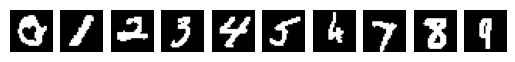

In [185]:
#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

In [192]:
class hopfield_network(object):
    """
    Define a class for a Hopfield network here.
    You must also define the functions below, but you can add additional arguments, etc.
    Also, note that you are welcome to write your own helper functions. 
    Reminder: you should use numpy functions for vector and matrix operations. No autograd!
    """

    # The initialization function for the hopfield network
    def __init__(self,N,lr=1):
        """
       Initialize the Hopfield network.

       Parameters:
           N (int): Number of neurons in the network.
           lr (float): Learning rate for updating weights and thresholds (default is 1).

       Attributes:
           self.state (numpy array): A vector of length N representing the current state of each neuron.
                                     Initially set to zeros.
           self.lr (float): The learning rate.
           self.w (numpy array): The weight matrix of shape (N, N) representing synaptic connections between neurons.
                                 Initialized to zeros, with the diagonal set to zero (no self-connections).
           self.threshold (numpy array): A vector of thresholds for each neuron, initialized to zero.
       """

        self.state = np.zeros((N,))  # Initialize the neuron state vector to zeros.
        self.lr = lr  # Set the learning rate.
        self.w = np.zeros((N, N))  # Initialize the weight matrix to zeros.
        np.fill_diagonal(self.w, 0)  # Remove self-connections by setting the diagonal to zero.
        self.threshold = np.zeros((N,))  # Initialize thresholds for each neuron to zero.



    # The function for setting the activity state of the network
    def set_state(self,activity):
        """
        set_state(activity)
        
        Sets the state of the network to the pattern given by activity.
        
        You do not need to change this function.
        """

        # set the state to activity
        self.state = activity

    # The function for updating the state of the network
    def update(self):
        """
        Update the state of a randomly selected neuron based on its local field.

        The net input to neuron i is computed as the weighted sum of inputs from all other neurons.
        If this input exceeds the neuron's threshold, the neuron is set to +1 (active); otherwise, to -1 (inactive).

        Returns:
            numpy array: The updated state of the network.
        """
        # Randomly select a neuron index to update.
        i = np.random.choice(len(self.state))

        # Compute the net input for the selected neuron
        net_i = np.dot(self.w[i, :], self.state)

        # Update the neuron's state based on the threshold
        if net_i > self.threshold[i]:
            self.state[i] = 1  # Neuron fires: state becomes +1.
        else:
            self.state[i] = -1  # Neuron does not fire: state becomes -1.

        return self.state

    
    def store_one(self, image):
        """
       Store a single image pattern into the network using a Hebbian learning rule.

       Parameters:
           image (numpy array): The input image, assumed to be in a 2D format.
       """
        flattened_image = image.flatten()
        activity = np.where(flattened_image > 0.5, 1, -1) # Convert the image to a binary activity pattern (+1 for values > 0.5, else -1).
        self.set_state(activity) # Set the network's state to the derived activity pattern.
        
        self.w = self.lr * np.outer(self.state, self.state) # Update the weight matrix using the Hebbian learning rule
        np.fill_diagonal(self.w, 0)  # Remove self-connections
        
        
    # The function for storing multiple images in one shot
    def store_multi(self,images):
        """
        Store multiple image patterns into the network.
        
        Parameters:
            images (list of numpy arrays): A list of images (each in 2D format) to be stored.
        """
        N = len(self.state) # number of neurons
        weights = []     # List to collect weight matrices for each image.
        
       
        for image in images:
            # Reset the weight matrix and threshold vector for each image.
            self.w = np.zeros((N, N))
            self.threshold = np.zeros((N,))

            # Flatten the image and convert it into a binary state pattern.
            flattened_image = image.flatten()
            activity = np.where(flattened_image > 0.5, 1, -1)
            self.set_state(activity) 

            self.w = self.lr * np.outer(self.state, self.state) # Compute W using the Hebbian rule.
            weights.append(self.w) # Save the computed weight matrix.

        self.w = np.sum(weights, axis=0) # Combine the weight matrices from all images by summing them.
        np.fill_diagonal(self.w, 0) # Remove self-connections


In [193]:
# Some helper functions for generating test images

# The function for generating a noisy version of an image
def image_noise(image,noise_level=0.1):
    """
    new_image = test_noise(image)
        
    This function takes an image, adds noise to it, and returns it. 

    noise_level - between 0-1, try experimenting with this

    """
    
    # create a mask for adding noise to the image
    image_mask = random.uniform(size=image.shape) < noise_level
    
    return np.logical_xor(image,image_mask)
    
# The function for generating a combo of two images
def image_combo(image1,image2,image1_weight=0.5):
    """
    newimage = test_combo(image1,image2)
        
    This function takes a pair of images, combines them, and returns the result.
    
    image1_weight - between 0-1, try experimenting with this

    """
    
    # create a mask for mixing the images
    image1_mask = random.uniform(size=image1.shape) < image1_weight
        
    return image1_mask*image1 + (1-image1_mask)*image2

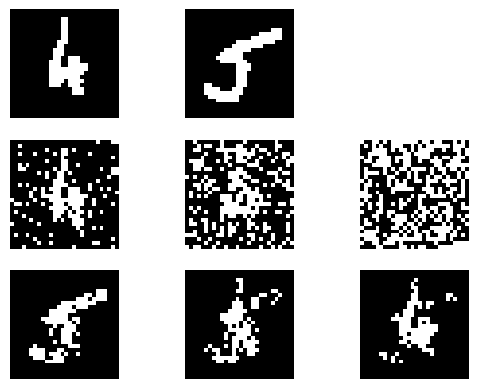

In [194]:
# Test the helper functions to make sure they work

# # Pick some random images
# image1 = patterns[random.randint(0,10)]
# image2 = patterns[random.randint(0,10)]

# # pick the most orthogonal images
image1 = patterns[6]
image2 = patterns[5]

# Create a little array for storage
test_images = np.zeros((2,3,784))

# Generate a series of noise images
test_images[0,0,:] = image_noise(image1)
test_images[0,1,:] = image_noise(image1,noise_level=0.3)
test_images[0,2,:] = image_noise(image1,noise_level=0.5)

# Generate a series of combo images
test_images[1,0,:] = image_combo(image1,image2,image1_weight=0.2)
test_images[1,1,:] = image_combo(image1,image2)
test_images[1,2,:] = image_combo(image1,image2,image1_weight=0.8)

# Plot the images, plus the originals on top
fig, axs = plt.subplots(3,3)
axs[0,0].imshow(image1.reshape((28,28)), cmap='gray')
axs[0,0].axis("off")
axs[0,1].imshow(image2.reshape((28,28)), cmap='gray')
axs[0,1].axis("off")
axs[0,2].axis("off")
for c in range(3):
    axs[1,c].imshow(test_images[0,c,:].reshape((28,28)), cmap='gray')
    axs[1,c].axis("off")
    axs[2,c].imshow(test_images[1,c,:].reshape((28,28)), cmap='gray')
    axs[2,c].axis("off")
plt.show()

In [197]:
# Create a Hopfield network and train it

one_pattern = False # flag for whether to store one pattern at a time

hnet = hopfield_network(784) # construct the network

if one_pattern:
    # Train the network to store all the patterns using your store_one function
    hnet.store_one(image1)
    
else:
    # Train the network to store all the patterns using your store_multi function 
    hnet.store_multi([image1, image2])

## Part 3

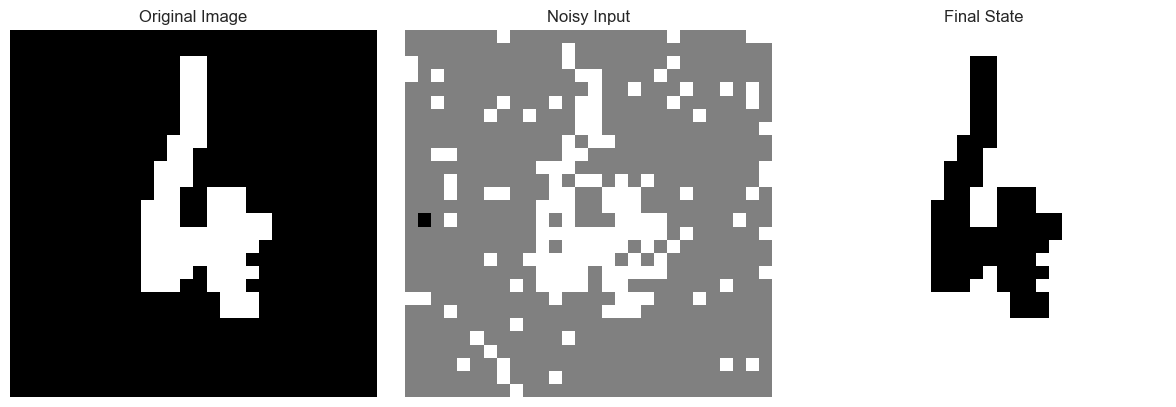

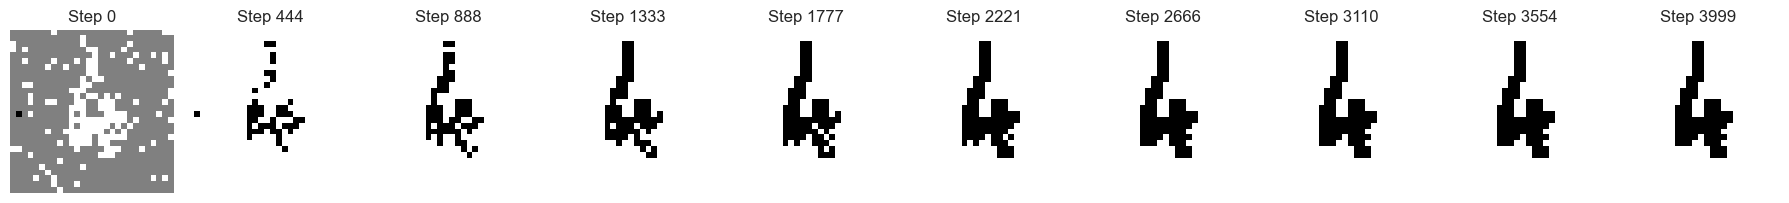

In [198]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is

# number of time-steps to run the network for
numsteps = 4000 # feel free to change this


# a noisy version of an image that was stored
activity = np.zeros((numsteps,784)) # each row is a timestep 
activity[0,:] = image_noise(image1, noise_level=0.1)
hnet.set_state(activity[0,:])


for t in range(numsteps-1):
    activity[t+1,:] = hnet.update()
    activity[t+1, :] = np.where(activity[t+1, :] >= 0, 1, -1)
    hnet.set_state(activity[t+1,:])


# Plot the original image, noisy input, and final recovered state
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Original image
axs[0].imshow(image1.reshape((28, 28)), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

# Noisy input
axs[1].imshow(activity[0, :].reshape((28, 28)), cmap='gray')
axs[1].set_title("Noisy Input")
axs[1].axis("off")

# Final recovered state
axs[2].imshow(activity[-1, :].reshape((28, 28)), cmap='gray')
axs[2].set_title("Final State")
axs[2].axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Number of snapshots
num_snapshots = 10
snapshot_indices = np.linspace(0, numsteps - 1, num_snapshots, dtype=int)

# Create the plot (only 1 row now)
fig, axs = plt.subplots(1, num_snapshots, figsize=(18, 3))

# Bottom row: Snapshots over time
for i, idx in enumerate(snapshot_indices):
    axs[i].imshow(activity[idx, :].reshape((28, 28)), cmap='gray')
    axs[i].set_title(f"Step {idx}")
    axs[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


### Part 3 Bonus

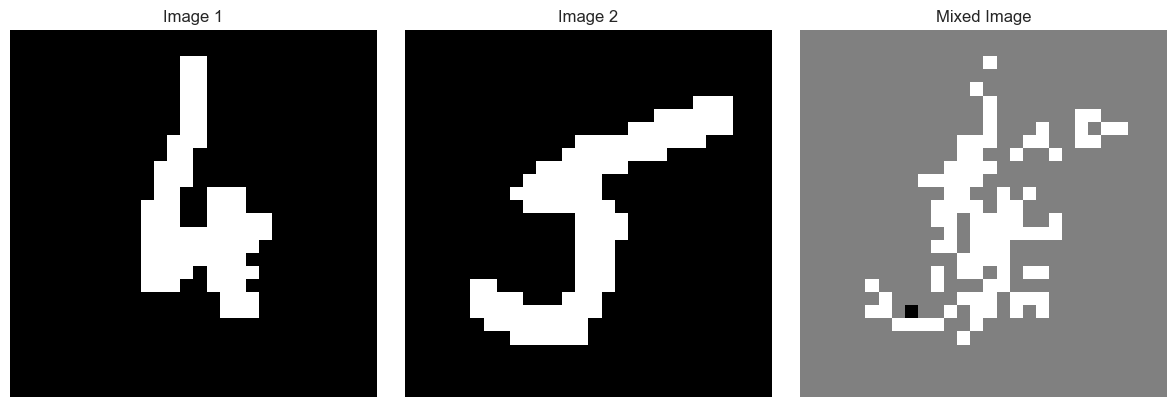

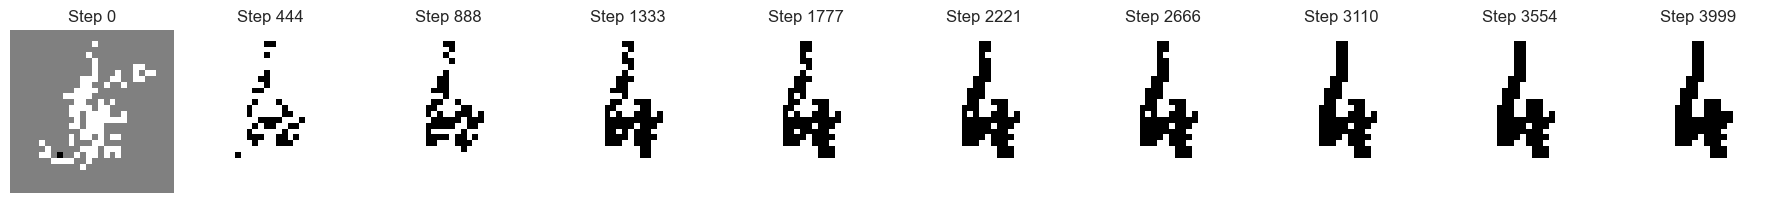

In [199]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is
# a combination of two images that were stored

# number of time-steps to run the network for
numsteps = 4000 # feel free to change this

# create an array for storing activity states over time
activity = np.zeros((numsteps,784))


activity[0,:] = image_combo(image1,image2)
hnet.set_state(activity[0,:])
for t in range(numsteps-1):
    activity[t+1,:] = hnet.update()
    activity[t+1, :] = np.where(activity[t+1, :] >= 0, 1, -1)
    hnet.set_state(activity[t+1,:])

# Plot the original image, noisy input, and final recovered state
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# image 1
axs[0].imshow(image1.reshape((28, 28)), cmap='gray')
axs[0].set_title("Image 1")
axs[0].axis("off")

# image 2
axs[1].imshow(image2.reshape((28, 28)), cmap='gray')
axs[1].set_title("Image 2")
axs[1].axis("off")

# mixed image
axs[2].imshow(activity[0,:].reshape((28, 28)), cmap='gray')
axs[2].set_title("Mixed Image")
axs[2].axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Number of snapshots
num_snapshots = 10
snapshot_indices = np.linspace(0, numsteps - 1, num_snapshots, dtype=int)

# Create the plot (only 1 row now)
fig, axs = plt.subplots(1, num_snapshots, figsize=(18, 3))

# Bottom row: Snapshots over time
for i, idx in enumerate(snapshot_indices):
    axs[i].imshow(activity[idx, :].reshape((28, 28)), cmap='gray')
    axs[i].set_title(f"Step {idx}")
    axs[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()